In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import numba
import zarr
import scipy.signal
from glob import glob
import re
interactive(True)
%matplotlib notebook

@numba.njit(parallel=True)
def std_along_first_axis(array):
    res = np.zeros(array.shape[1:])
    for i in numba.prange(array.shape[1]):
        for j in range(array.shape[2]):
            res[i, j] = np.std(array[:,i,j])
    return res

def prefix_suffix_number(name, suffix, prefix = "_"):
    pat = prefix + r"([0-9\.]+)" + suffix
    return float(re.search(pat, name).group(1))

In [2]:
def frame_fig(frame, title = None, title_prefix = None, nσ = 3, **kwargs):
    if isinstance(frame, tuple):
        frame, meta = frame
        if title is None:
            title = f"ms = {meta['exposure_ms']}, gain = {meta['gain']}, n = {meta['n_frames']}"
    if title is not None and title_prefix is not None:
        title = title_prefix + " " + title
    plt.figure(figsize=(11,6))
    μ = np.mean(frame)
    σ = np.std(frame)
    plt.imshow(frame, vmin = μ - nσ * σ, vmax = μ + nσ * σ, **kwargs)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    
def save_all_as_pdf(name):
    pdf = PdfPages(name)
    for n in plt.get_fignums():
        plt.figure(n).savefig(pdf, format="pdf")
    pdf.close()

In [3]:
def load_frames(gain = "1.0"):
    frames = []
    for frame in glob(f"capture/darkframe_{gain}x*.blob"):
        metadata = {}
        metadata["gain"] = float(gain)
        metadata["exposure_ms"] = prefix_suffix_number(frame, "ms")
        metadata["n_frames"] = prefix_suffix_number(frame, "n")
        arr = np.memmap(frame, dtype=np.float32).reshape((-1, 4096))
        if arr.shape[0] != 0:
            frames.append((arr, metadata))
            
            
    return list(sorted(frames, key=lambda frame_meta: frame_meta[1]["exposure_ms"]))

<IPython.core.display.Javascript object>


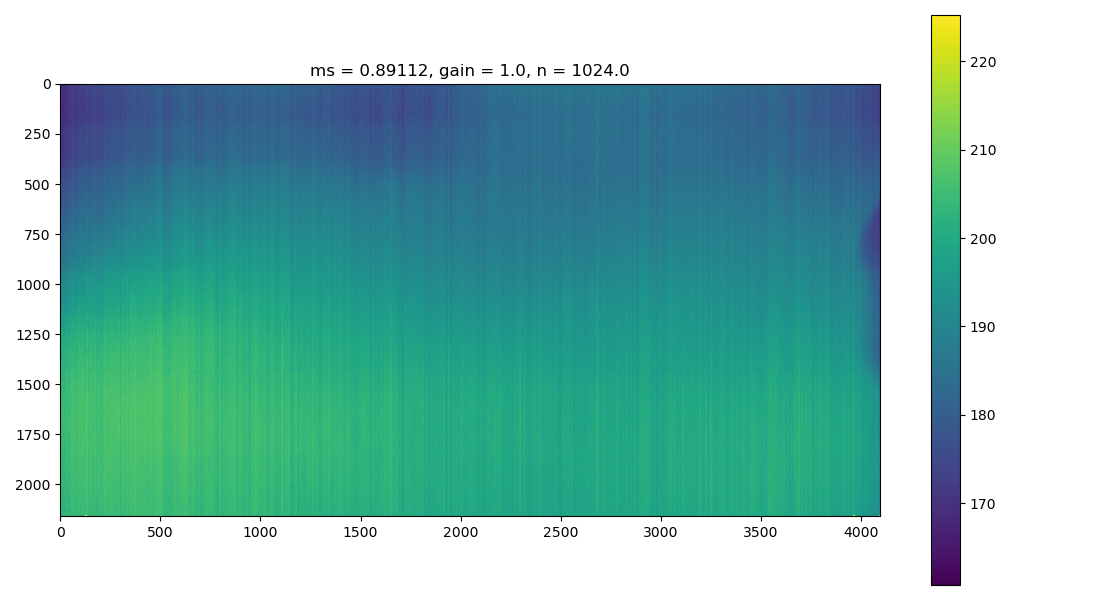

<IPython.core.display.Javascript object>


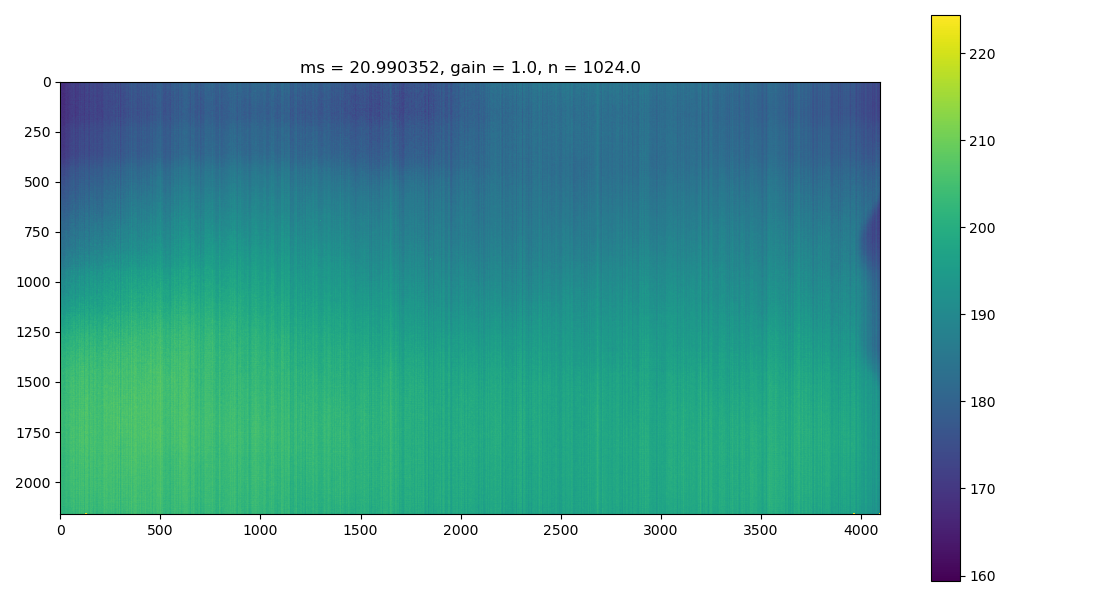

<IPython.core.display.Javascript object>


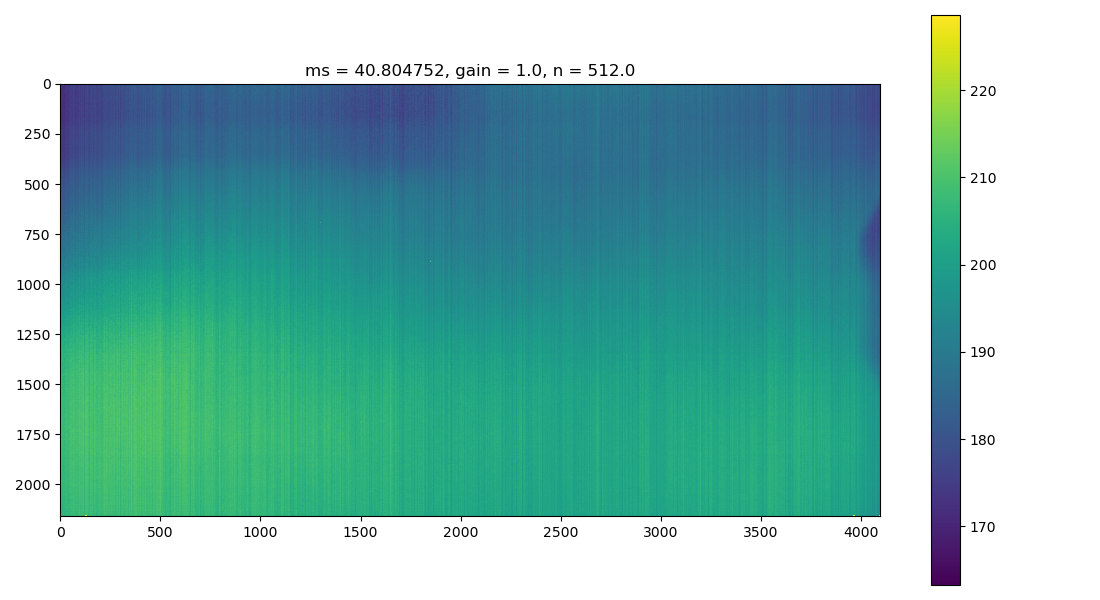

<IPython.core.display.Javascript object>


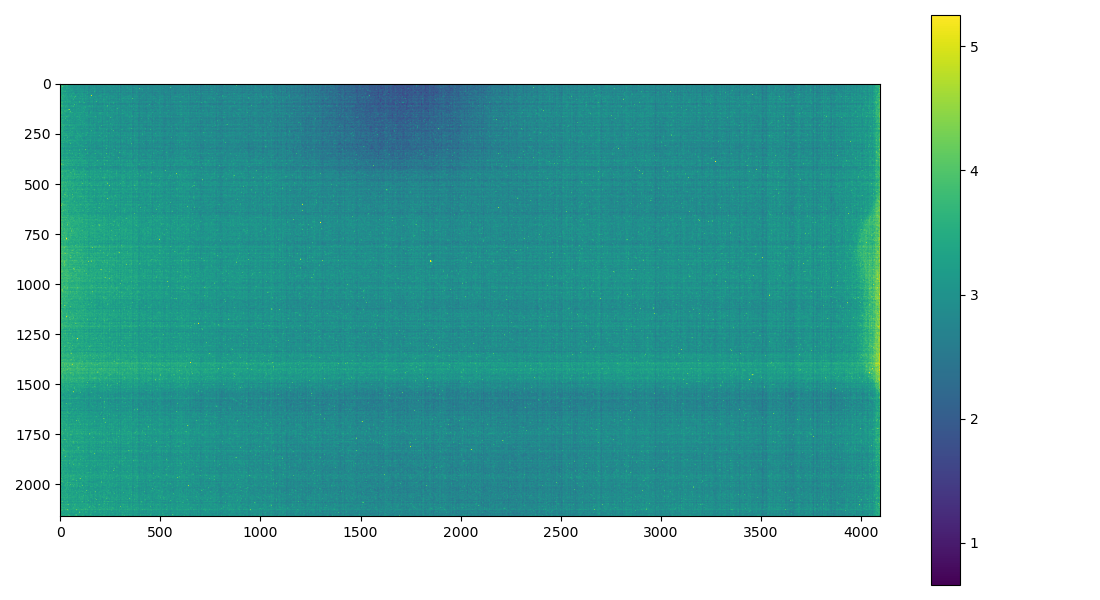

<IPython.core.display.Javascript object>


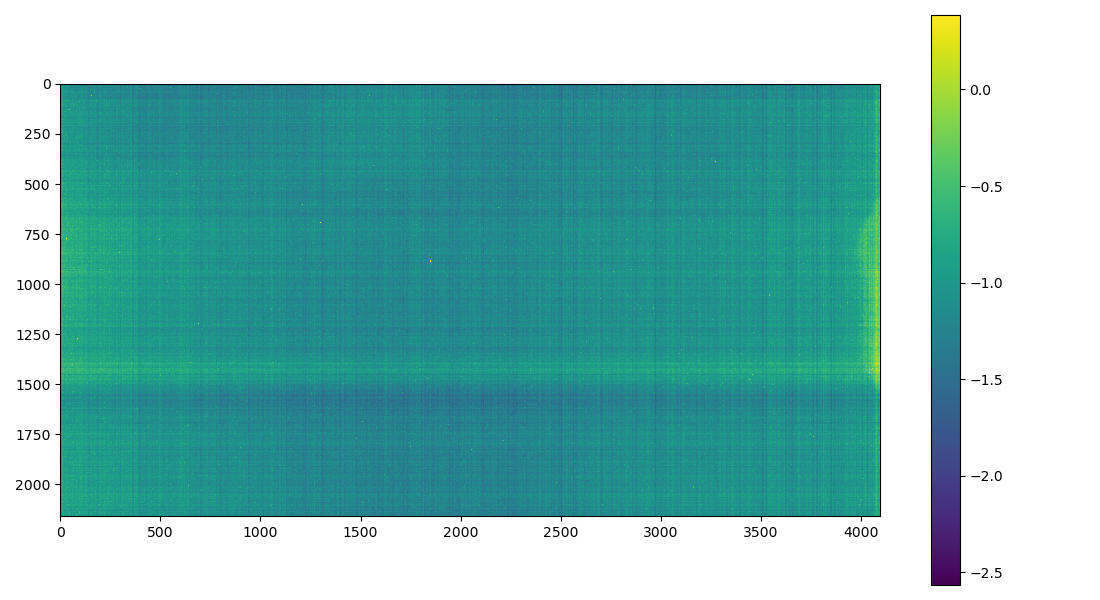

In [4]:
gain = "1.0"

frames = load_frames(gain=gain)[:50]

frame_fig(frames[0])
frame_fig(frames[len(frames) // 2])
frame_fig(frames[-1])

frame_fig(frames[-1][0] - frames[0][0])
frame_fig(frames[len(frames) // 2][0] - frames[0][0])

In [5]:
x = np.array([meta["exposure_ms"] for _, meta in frames])
y = np.vstack([np.ravel(frame) for frame, _ in frames])
print(x.shape)
print(y.shape)
fit_degree = 2
fit = np.polyfit(x, y, fit_degree)
print(fit.shape)

(50,)
(50, 8847360)
(3, 8847360)


<IPython.core.display.Javascript object>


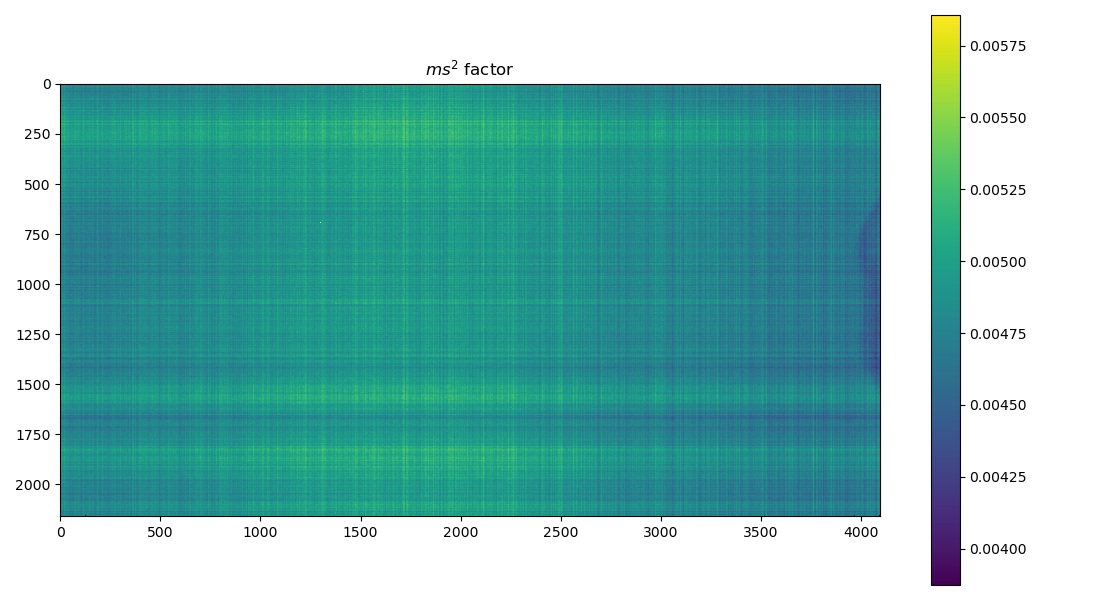

<IPython.core.display.Javascript object>


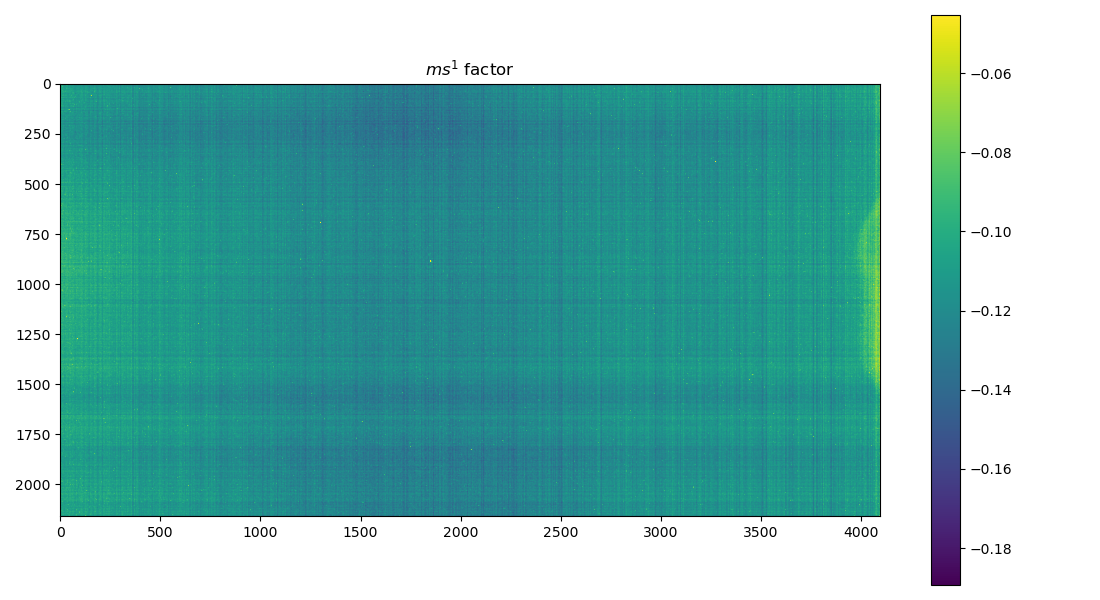

<IPython.core.display.Javascript object>


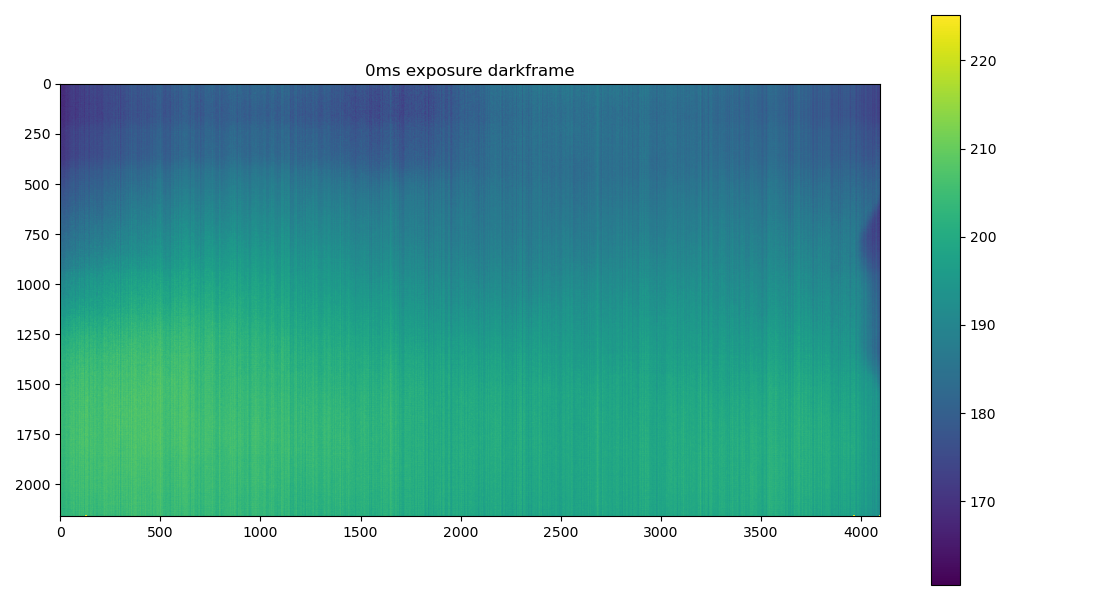

In [6]:
for part in range(fit_degree + 1):
    title = f"$ms^{fit_degree - part}$ factor"
    if part == fit_degree:
        title = "0ms exposure darkframe"
    frame_fig(fit[part].reshape(-1, 4096), title)

<IPython.core.display.Javascript object>


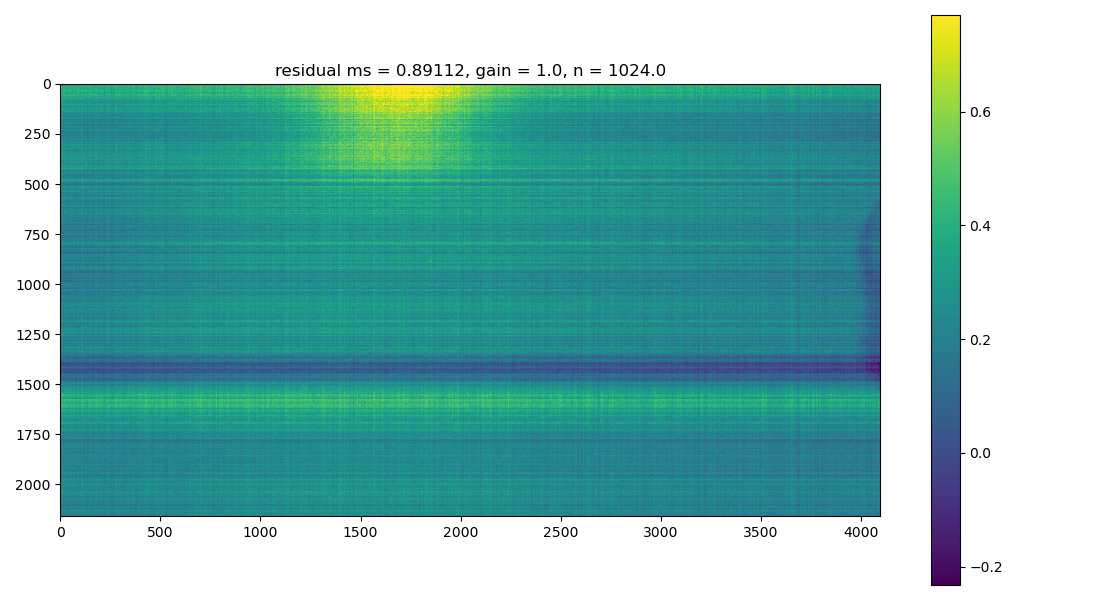

<IPython.core.display.Javascript object>


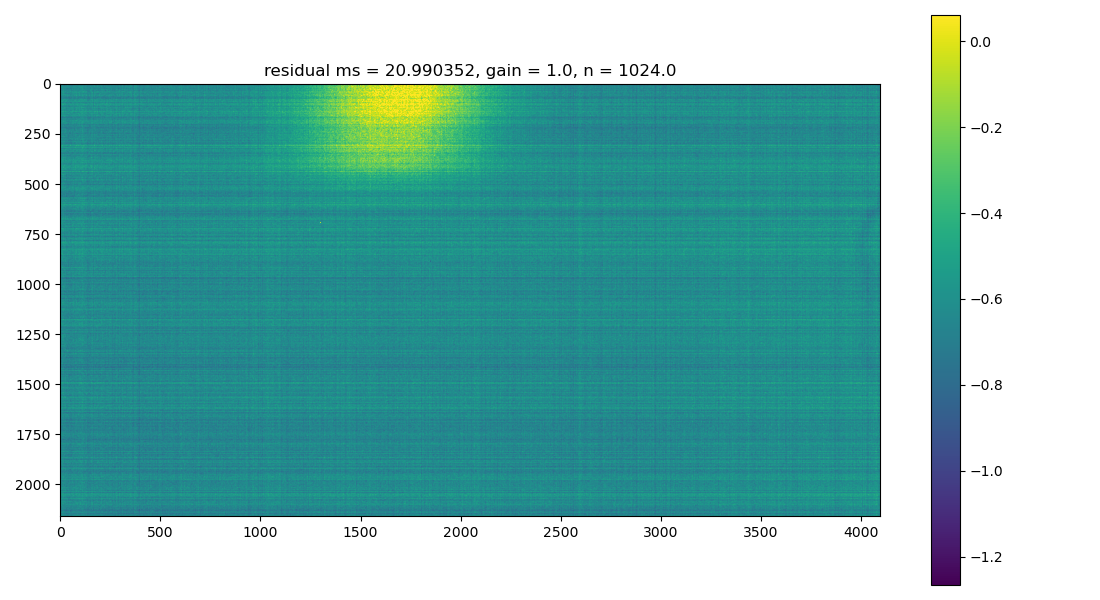

<IPython.core.display.Javascript object>


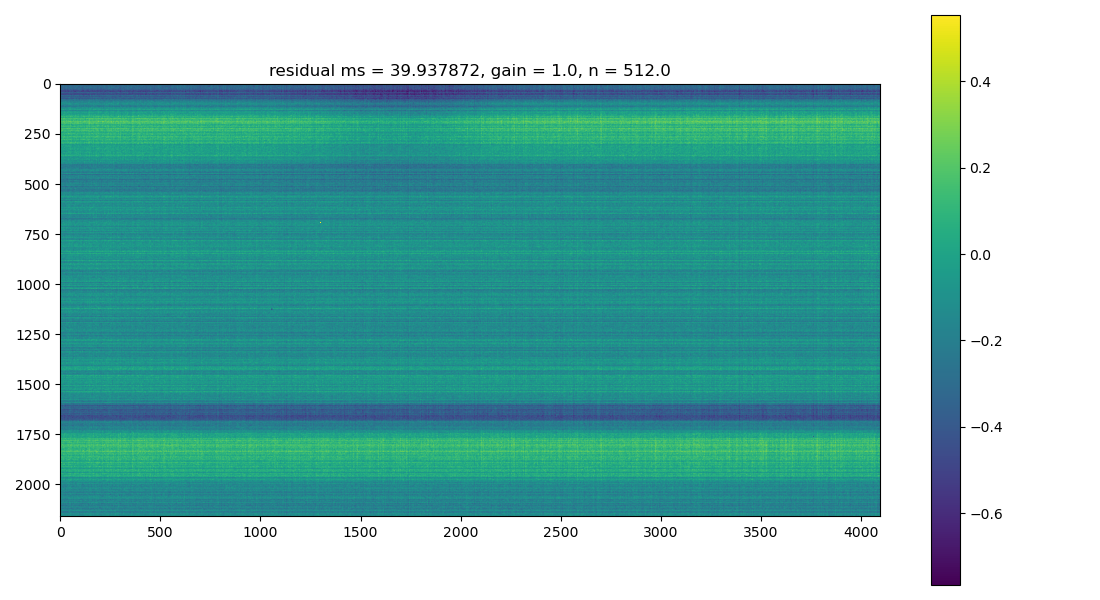

total residual 2125188.976130645


In [7]:
def fit_estimate(ms):
    res = np.zeros_like(fit[0])
    for part in fit:
        res *= ms
        res += part
    return res.reshape(-1, 4096)

def correct_frame(frame_meta):
    frame, meta = frame_meta
    ms = meta["exposure_ms"]
    return (frame - fit_estimate(ms), meta)

frame_fig(correct_frame(frames[0]), title_prefix="residual")
frame_fig(correct_frame(frames[len(frames) // 2]), title_prefix="residual")
frame_fig(correct_frame(frames[-2]), title_prefix="residual")

save_all_as_pdf(f"darkframe_{gain}x_residual_examples.pdf")

total_residual = sum(np.sum(np.square(correct_frame(frame)[0])) for frame in frames) / len(frames)
print(f"total residual {total_residual}")

In [8]:
bins = np.linspace(-2 * float(gain) / 1.1 / 4**(1 if fit_degree > 1 else 0), 2.5 * float(gain) / 1.1 / 4**(1 if fit_degree > 1 else 0), 100)
hist2d = np.vstack([
    np.histogram(correct_frame(frame)[0], bins=bins)[0]    
    for frame in frames
])

<IPython.core.display.Javascript object>


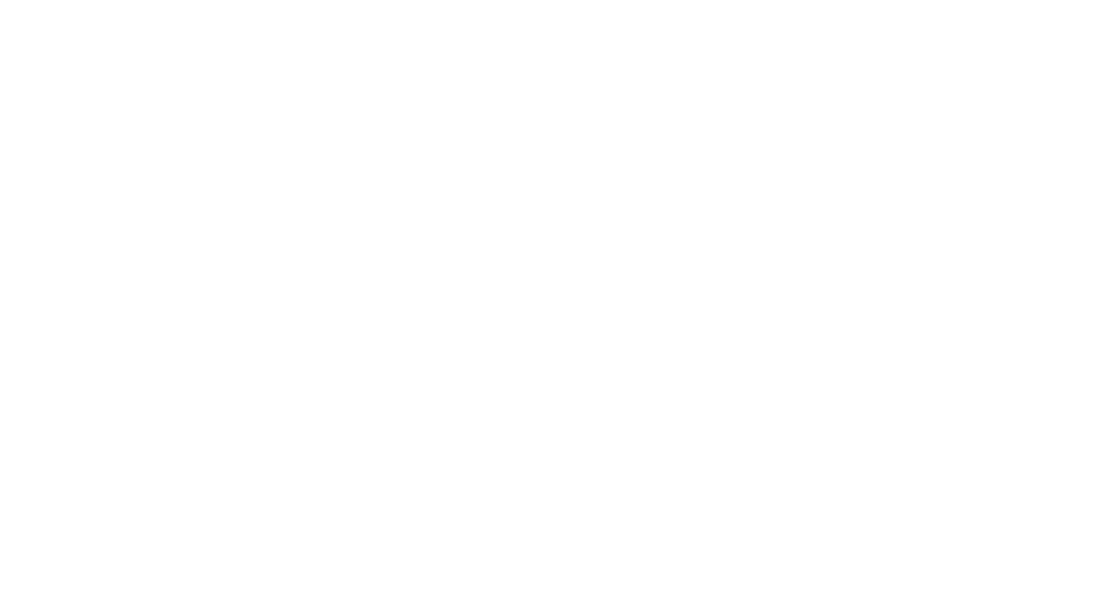

In [9]:
part = hist2d[:,:]
mss = np.array([meta["exposure_ms"] for _, meta in frames[:part.shape[0]]])
bins_x = np.concatenate([[0], mss])
x_grid, y_grid = np.meshgrid(bins_x, bins)
plt.figure(figsize=(11,6))
plt.pcolor(x_grid, y_grid, part.T) #, norm=matplotlib.colors.LinearNorm())
plt.colorbar()
plt.xlabel("exposure [ms]")
plt.ylabel("residual")
plt.tight_layout()
plt.savefig(f"darkframe_{gain}x_residual_linear_model.pdf")
plt.show()

In [10]:
def compare(gain, ms):
    idx = np.argmin(np.abs(np.array([meta["exposure_ms"] for _, meta in frames]) - float(ms)))
    gain = int(gain)
    filename = re.sub(r"_[0-9\.]+x", f"_{gain}.0x", frames[idx][0].filename)
    print(filename)
    new = np.memmap(filename, dtype=np.float32).reshape((2160, -1))[:,128:3840 + 128]
    new_ms = frames[idx][1]["exposure_ms"]
    
    old = zarr.open(f"darkframe_{gain}x_{ms}.blob.mean.zarr")[:].reshape((2160, -1))
    old_ms = float(ms)
    
    corr = scipy.signal.correlate(new, old, method="fft")
    
    # frame_fig(corr)save_all_as_pdfsave_all_as_pdf
    
    # frame_fig(new, "new")
    # frame_fig(old, "old")
    frame_fig(new - old, title=f"gain {gain}x, new ({new_ms} ms) - old ({old_ms} ms)")

# darkframe_1.0x_5.052144ms_1024n.blob
# darkframe_1.0x_10.042896ms_1024n.blob


In [11]:
# plt.close('all')
# for gain in range(1,5):
#     compare(gain, "4.990224")
#     compare(gain, "9.99336")
    
# save_all_as_pdf("darkframe_comparison.pdf")

<IPython.core.display.Javascript object>


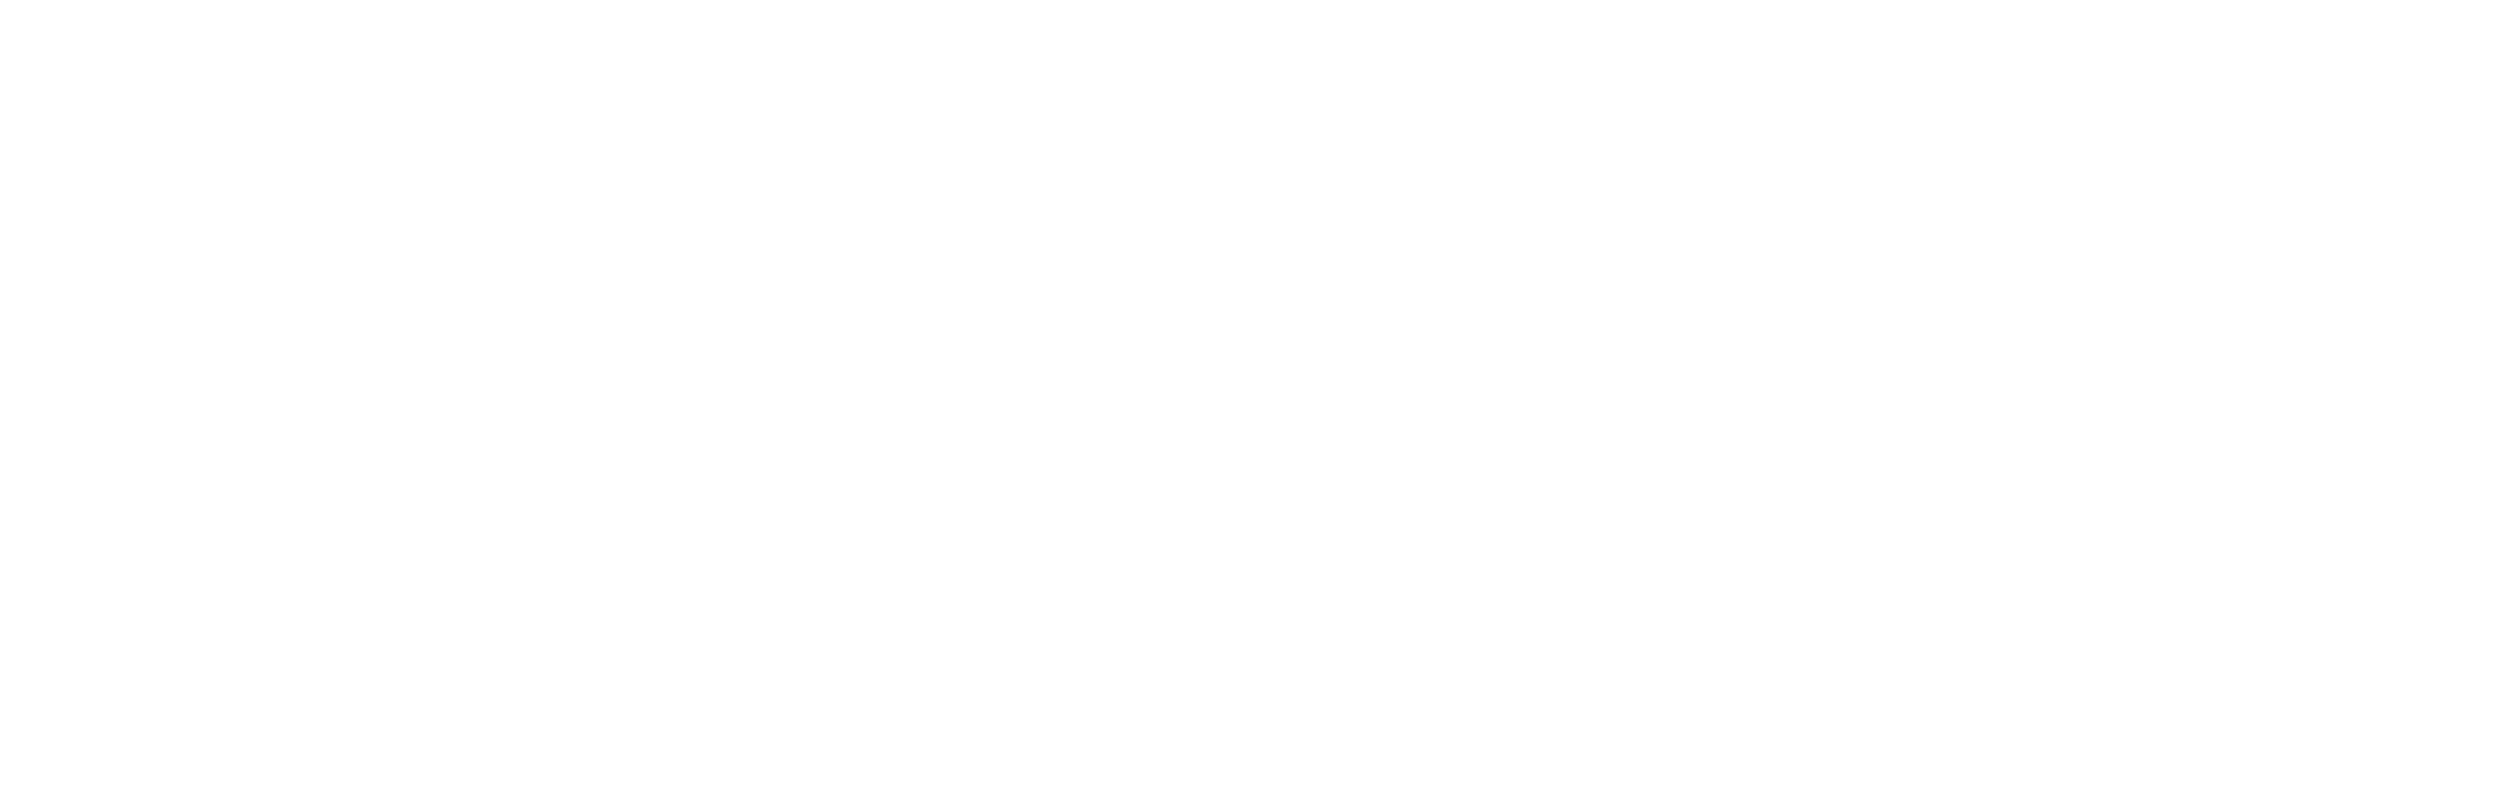

In [12]:
plt.figure(figsize=(25,8))
plt.ylim([-4,4])
plt.xlim([0, 52])
plt.violinplot([np.random.choice(np.ravel(correct_frame(frame)[0]), 100000, replace=False) for frame in frames], widths=1.0, showmeans=True, quantiles=[[0.01,0.99]]*len(frames), showextrema=False)
plt.tight_layout()
plt.savefig("violin.pdf")